<a href="https://colab.research.google.com/github/matthiasweidlich/privacy_series_tutorial/blob/main/privacy_tutor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Privacy-aware Analysis of Data Series

This notebook demonstrates techniques for the privacy-aware analysis of data series, as they are generated in process-oriented systems. The notebook relies on data of the _Sepsis Event Log_. We first give information on the respective event log, before demonstrating some basic analysis tasks on the original log as well as on a privatized one.  

## Background on the Sepsis Event Log

DOI: [doi:10.4121/uuid:915d2bfb-7e84-49ad-a286-dc35f063a460](https://doi.org/10.4121/uuid:915d2bfb-7e84-49ad-a286-dc35f063a460)

Author: [Felix Mannhardt (Eindhoven University of Technology)](https://www.tue.nl/en/research/researchers/felix-mannhardt)

> This real-life event log contains events of sepsis cases from a hospital. Sepsis is a life threatening condition typically caused by an infection. One case represents the pathway through the hospital. The events were recorded by the ERP (Enterprise Resource Planning) system of the hospital. There are about 1000 cases with in total 15,000 events that were recorded for 16 different activities. Moreover, 39 data attributes are recorded, e.g., the group responsible for the activity, the results of tests and information from checklists. Events and attribute values have been anonymized. The time stamps of events have been randomized, but the time between events within a trace has not been altered.

An event in the Sepsis event log contains the following attributes:

| Name | Description |
| --- | --- |
|Age			| Age in 5-year groups|
|Diagnostic*		| Various checkboxes on the triage document|
|DisfuncOrg		| Checkbox: Disfunctional organ|
|Hypotensie		| Checkbox: Hypotension |
|Hypoxie 		| Checkbox: Hypoxia|
|InfectionSuspected 	| Checkbox: Suspected infection|
|Infusion 		| Checkbox: Intravenous infusion required|
|Oligurie		| Checkbox: Oliguria |
|SIRSCritHeartRate	| Checkbox: One of the SIRS criteria|
|SIRSCritLeucos		| Checkbox: One of the SIRS criteria|
|SIRSCritTachypnea	| Checkbox: One of the SIRS criteria|
|SIRSCritTemperature	| Checkbox: One of the SIRS criteria|
|SIRSCriteria2OrMore	| Checkbox: Two or more of the SIRS criteria |
|Leucocytes		| Leucocytes measurement
|CRP			| CRP measurement|
|LacticAcid		| Lactic-acid measurement|

## Basic Configuration and Setup

Below, we provide some basic notebook configuration, fetch the event log, and install the [PM4Py library](https://pypi.org/project/pm4py/) for process mining tasks.


In [1]:
# basic configuration for the notebook
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# fetch the event log
! wget -O sepsis_event_log.xes.gz https://data.4tu.nl/file/33632f3c-5c48-40cf-8d8f-2db57f5a6ce7/643dccf2-985a-459e-835c-a82bce1c0339
! gzip -dv sepsis_event_log.xes.gz

log_file = 'sepsis_event_log.xes'

# Install the PM4Py library for process mining
! pip install pm4py
# Install the DiffPrivLib library for differential privacy
!pip install diffprivlib

--2024-05-14 23:26:43--  https://data.4tu.nl/file/33632f3c-5c48-40cf-8d8f-2db57f5a6ce7/643dccf2-985a-459e-835c-a82bce1c0339
Resolving data.4tu.nl (data.4tu.nl)... 131.180.169.22
Connecting to data.4tu.nl (data.4tu.nl)|131.180.169.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202508 (198K) [application/octet-stream]
Saving to: ‘sepsis_event_log.xes.gz’

sepsis_event_log.xe 100%[===================>] 197.76K   685KB/s    in 0.3s    

2024-05-14 23:26:44 (685 KB/s) - ‘sepsis_event_log.xes.gz’ saved [202508/202508]

sepsis_event_log.xes.gz:	 96.3% -- replaced with sepsis_event_log.xes
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=be90573f6c538a07deea6f2ab5fea68a9aa6f540b759593f6697e4e693b76659
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4

## Importing the Event Log
We shortly illustrate the XES XML format by opening it in a browserand then use the PM4Py library to load the event log.

In [2]:
import pm4py
import webbrowser

#webbrowser.open(log_file)
log = pm4py.read_xes(log_file)

print('The log contains %s events.\n' % len(log))
print('Each event has the following attributes:')
print(log.columns.tolist(), '\n')
print('Let us look at the first 40 events, only at a few attributes:')
print(log.head(40)[['time:timestamp', 'case:concept:name', 'concept:name', 'Leucocytes']])


/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

The log contains 15214 events.

Each event has the following attributes:
['InfectionSuspected', 'org:group', 'DiagnosticBlood', 'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate', 'Infusion', 'DiagnosticArtAstrup', 'concept:name', 'Age', 'DiagnosticIC', 'DiagnosticSputum', 'DiagnosticLiquor', 'DiagnosticOther', 'SIRSCriteria2OrMore', 'DiagnosticXthorax', 'SIRSCritTemperature', 'time:timestamp', 'DiagnosticUrinaryCulture', 'SIRSCritLeucos', 'Oligurie', 'DiagnosticLacticAcid', 'lifecycle:transition', 'Diagnose', 'Hypoxie', 'DiagnosticUrinarySediment', 'DiagnosticECG', 'case:concept:name', 'Leucocytes', 'CRP', 'LacticAcid'] 

Let us look at the first 40 events, only at a few attributes:
        time:timestamp case:concept:name      concept:name  Leucocytes
0  2014-10-22 11:15:41                 A   ER Registration         NaN
1  2014-10-22 11:27:00                 A        Leucocytes         9.6
2  2014-10-22 11:27:00                 A               CRP         NaN
3  20

## Exploring Log Properties
After loading the event log let us first examine some basic properties of it, such as the number of traces, the min/max length of traces, and their length distribution.  

The log contains 1050 traces.

The longest trace contains 185 events. The shortest trace: 3 events.

The distribution of the trace lengths is:



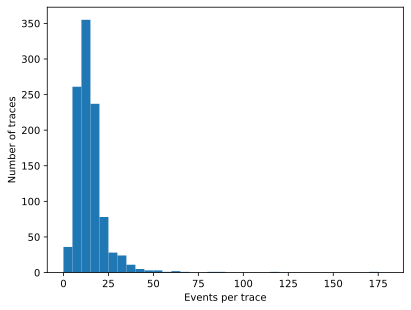

In [ ]:
import matplotlib.pyplot as plt

traces = log.groupby(['case:concept:name'])

trace_lengths = []
for trace in traces:
    trace_lengths.append(len(trace[1]))

trace_lengths = sorted(trace_lengths)
max_length = trace_lengths[-1]
min_length = trace_lengths[0]

print('The log contains %s traces.\n' % len(traces))

print('The longest trace contains %s events. The shortest trace: %s events.\n' %(max_length, min_length))

print('The distribution of the trace lengths is:\n')

plt.hist(trace_lengths, bins=range(0, max_length, 5))
plt.xlabel('Events per trace')
plt.ylabel('Number of traces')
plt.show()


Next, we focus on the trace variants and derive their total number and distribution. Moreover, let us explore the top-3 most frequent trace variants.

The log contains 846 trace variants.

The variants that are top-3 most frequent are:
Variant with 35 traces: ('ER Registration', 'ER Triage', 'ER Sepsis Triage')
Variant with 24 traces: ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP')
Variant with 22 traces: ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'CRP', 'Leucocytes')

The distribution of the trace variants is:



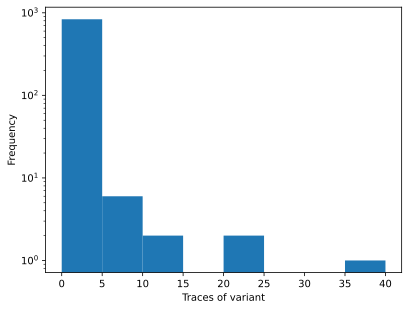

In [ ]:
trace_variants = pm4py.stats.get_variants(log)
print('The log contains %s trace variants.\n' % len(trace_variants.keys()))

print('The variants that are top-3 most frequent are:')
top_count = sorted(trace_variants.values())[-3:]
for v,c in {v: c for v, c in trace_variants.items() if c in top_count}.items():
    print('Variant with %s traces: %s' %(c,v))

print('\nThe distribution of the trace variants is:\n')

plt.hist(trace_variants.values(), bins=range(0, max(trace_variants.values())+10, 5))
plt.xlabel('Traces of variant')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()


## Exploring Log Properties
After loading the event log let us first examine some basic properties of it, such as the number of traces, the min/max length of traces, and their length distribution.  The performance perspective is typically important for process analysis. We consider it in terms of basic descriptive statistics, such as the average case arrival rate and the cycle time of the underlying process. Moreover, we consider the distribution of case durations to explore the variance in the cycle times. Finally, we consider the distribution of the start times of cases over the days of week as an example for another exploratory analysis.


The average difference between the start times of two consecutive cases is 39207.71.

The average case duration is 683.26 hours.

The longest trace duration is 10135.77 hours. The shortest trace duration: 0.03 hours.

The distribution of the case durations is:



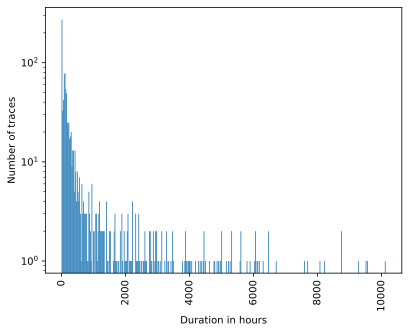

In [ ]:

print('\nThe average difference between the start times of two consecutive cases is %s.\n' % round(pm4py.stats.get_case_arrival_average(log),2))

durations = sorted(pm4py.stats.get_all_case_durations(log))

durations = list(map(lambda d : round(d / 3600, 2), durations))

max_duration = durations[-1]
min_duration = durations[0]

print('The average case duration is %s hours.\n' % round((sum(durations) / len(durations)),2))

print('The longest trace duration is %s hours. The shortest trace duration: %s hours.\n' %(max_duration, min_duration))

print('The distribution of the case durations is:\n')

plt.hist(durations, bins=range(0, round(max_duration), 24))
plt.gca()
plt.xticks(rotation='vertical')
plt.xlabel('Duration in hours')
plt.ylabel('Number of traces')
plt.yscale('log')
plt.show()


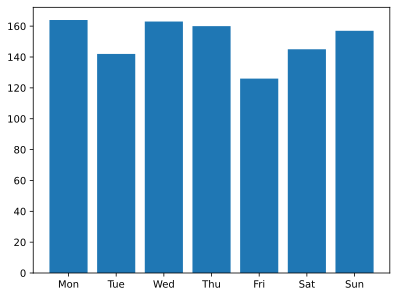

In [ ]:

from datetime import datetime, timedelta
import numpy as np

weekdays = [1,2,3,4,5,6,7]

for trace in traces:
    start = trace[1]['time:timestamp'].tolist()[0]
    weekdays.append(start.isoweekday())

data = np.bincount(weekdays)[1:]
x_ticks = range(0,len(data), 1)
plt.bar(x_ticks, data)
ax = plt.gca()
ax.set_xticks(x_ticks)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

## Constructing Models from the Log
Finally, we consider the construction of a model from the log.   

Discover a simple model represented as a directly-follows-graph (DFG).


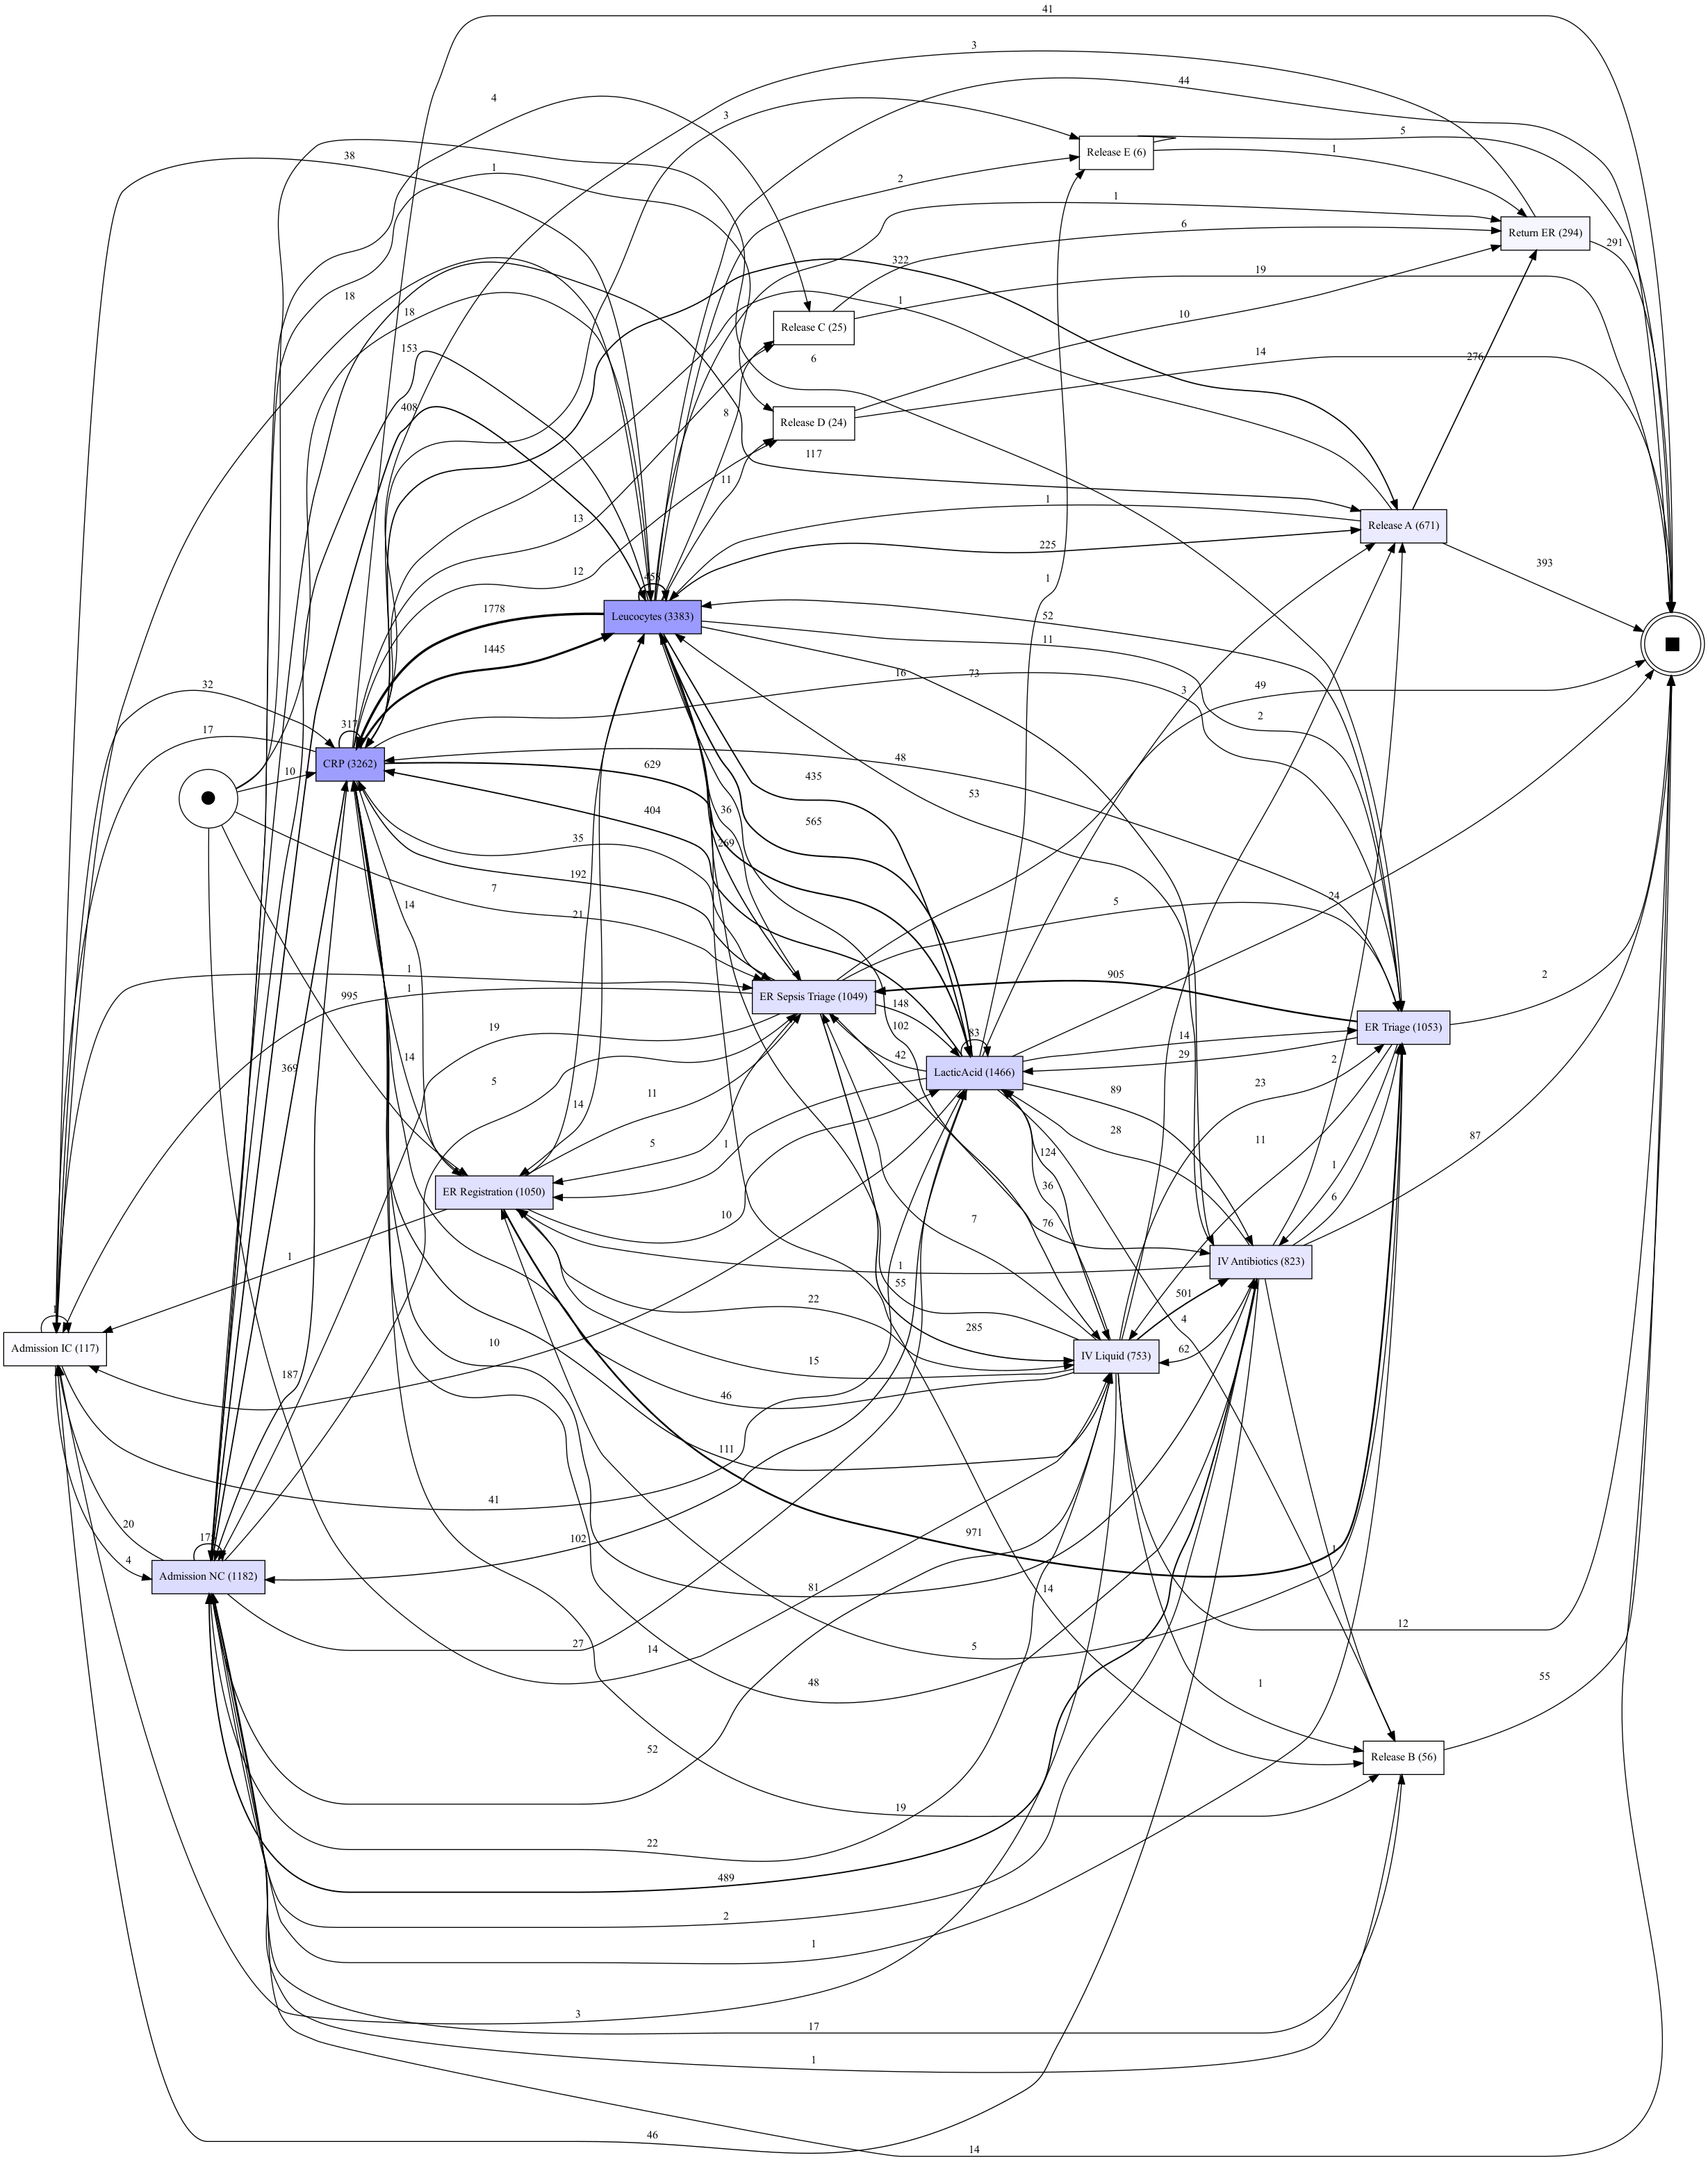

Discover a process modell following the BPMN standard.


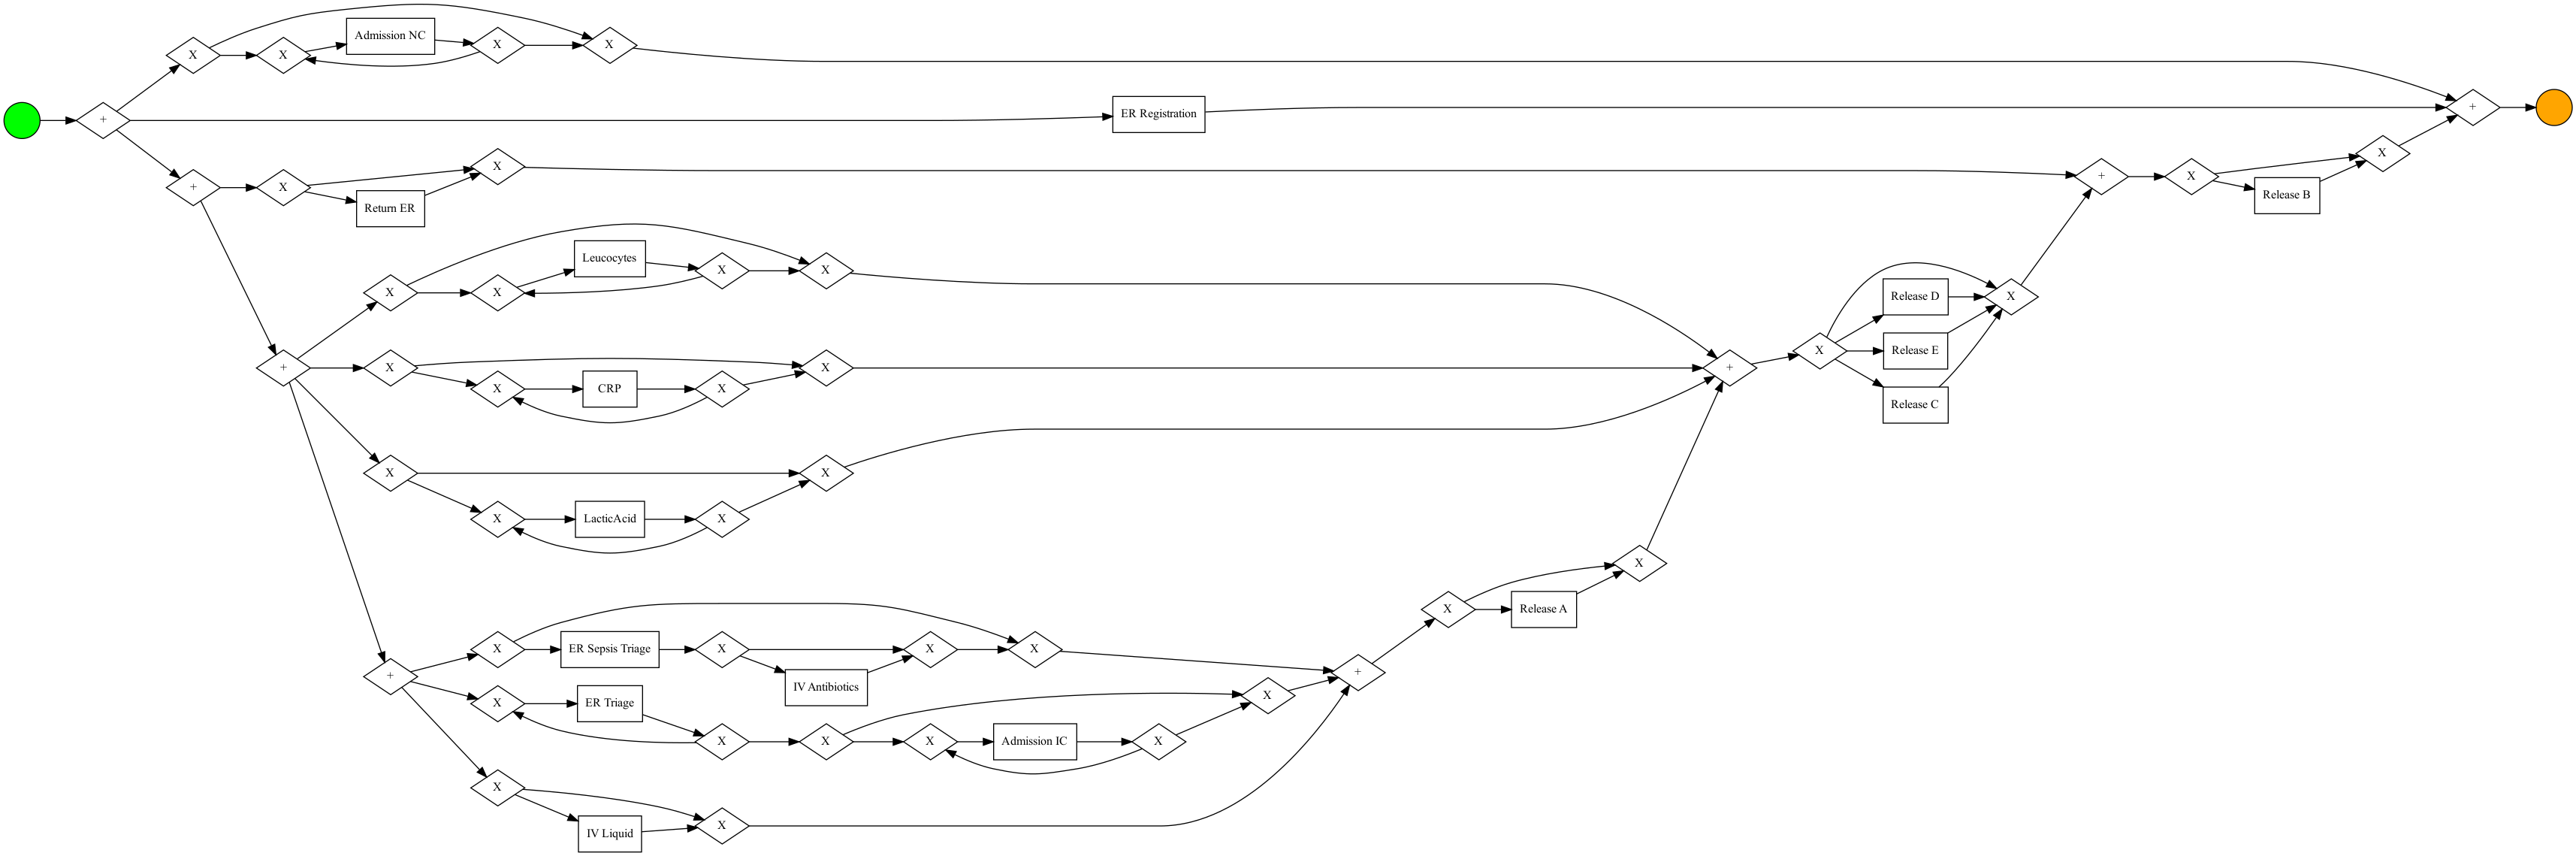

In [ ]:

print('Discover a simple model represented as a directly-follows-graph (DFG).')
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.view_dfg(dfg, start_activities, end_activities)

print('Discover a process modell following the BPMN standard.')
bpmn_model = pm4py.discover_bpmn_inductive(log)
pm4py.view_bpmn(bpmn_model)


The above models show a lot of variance, so that we also considered the model created for a filtered log, keeping only the variants that show a certain coverage.

Construct a simple model represented as a directly-follows-graph (DFG), but now for a noise filtered log.


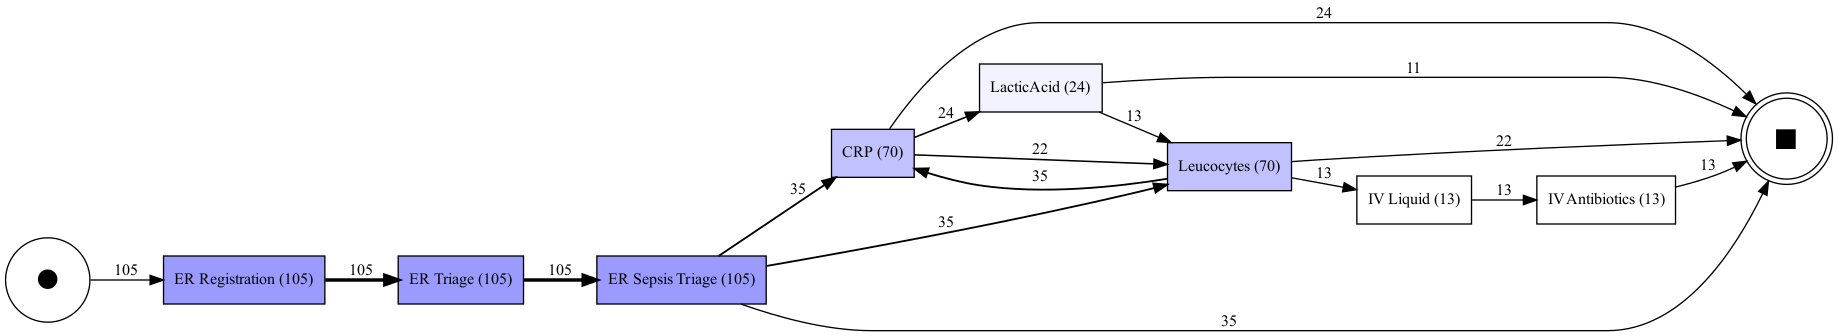

In [ ]:

print('Construct a simple model represented as a directly-follows-graph (DFG), but now for a noise filtered log.')
filtered_log = pm4py.filter_variants_by_coverage_percentage(log, 0.01)
dfg, start_activities, end_activities = pm4py.discover_dfg(filtered_log)
pm4py.view_dfg(dfg, start_activities, end_activities)


## Create a Privatized Version of the Log
Now, privatize the given event log, using SaCoFa and PRIPEL to achieve differential privacy for the control-flow of the event log as well as the contextual information linked to the events.   

In [ ]:
# The strength of the differential privacy guarantee. The smaller the value of epsilon, the stronger the privacy guarantee that is provided.
epsilon = 1.0
# The maximal length of considered traces in the prefix tree. We recommend setting k, that roughly 80% of all traces from the original event log are covered.
k = 20
# The pruning parameter, which denotes the minimum count a prefix has to have in order to not be discarded. The dependent exponential runtime of the algorithms is mitigated by the pruning parameter.
p = 3

anonymized_log = pm4py.anonymize_differential_privacy(log, epsilon, k, p)

prefix tree construction, completed prefixes of length ::   0%|          | 0/20 [00:00<?, ?it/s]

matching query traces, matched traces ::   0%|          | 0/412 [00:00<?, ?it/s]

attribute anonymization, anonymized traces ::   0%|          | 0/412 [00:00<?, ?it/s]

## Comparison of Results for the Anonymized Log and the Original Log
For illustration purposes, we take up some of the log properties, performance details and model constructions from above and assess the impact of the privatization.   

The anonymized log contains 412 traces, whereas the original log contains 1050 traces.

The longest anonymized trace contains 15 events, compared to 185 events in the original log. The shortest anonymized trace: 1 events, compared to 3 in the original log.

The trace length distributions compare as follows:



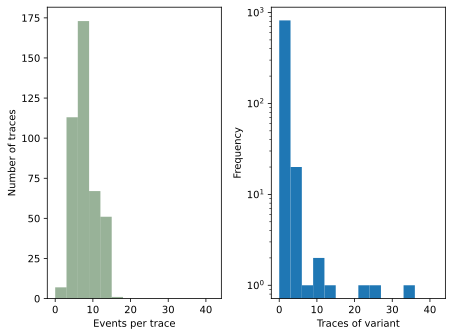

In [ ]:
anonymized_traces = anonymized_log.groupby(['case:concept:name'])

anonymized_trace_lengths = []
for trace in anonymized_traces:
    anonymized_trace_lengths.append(len(trace[1]))

anonymized_trace_lengths = sorted(anonymized_trace_lengths)
anonymized_max_length = anonymized_trace_lengths[-1]
anonymized_min_length = anonymized_trace_lengths[0]

print('The anonymized log contains %s traces, whereas the original log contains %s traces.\n' % (len(anonymized_traces),len(traces)))

print('The longest anonymized trace contains %s events, compared to %s events in the original log. The shortest anonymized trace: %s events, compared to %s in the original log.\n' %(anonymized_max_length, max_length, anonymized_min_length, min_length))

print('The trace length distributions compare as follows:\n')

color = (0.2, 0.4, 0.2, 0.5)
plt.subplot(1, 2, 1)
plt.hist(anonymized_trace_lengths, bins=range(0, max(trace_variants.values())+10, 3), color=color)
plt.xlabel('Events per trace')
plt.ylabel('Number of traces')
plt.subplot(1, 2, 2)
plt.hist(trace_variants.values(), bins=range(0, max(trace_variants.values())+10, 3))
plt.xlabel('Traces of variant')
plt.ylabel('Frequency')
plt.yscale('log')
plt.tight_layout()
plt.show()

## -- End